In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import statistics
import numpy as np
from scipy.stats import mstats
import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

import time
from zipfile import ZipFile
from io import BytesIO
from urllib import request
import sqlite3

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Setting up data and variables

In [ ]:
# Reading zip file from url
read_url = request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip').read()

In [ ]:
# Displaying file names in zip
myzip = ZipFile(BytesIO(read_url))
myzip.namelist()

['student-mat.csv', 'student-por.csv', 'student-merge.R', 'student.txt']

In [ ]:
# Extracting and reading csvs
extracted = myzip.extract('student-mat.csv')
math_data = pd.read_csv(extracted,
                        sep=';')
extracted = myzip.extract('student-por.csv')
language_data = pd.read_csv(extracted,
                            sep=';') 

Now we need to combine math and language into one dataframe, but we want to be able to differentiate between the math and language rows later, so first we'll create a new column identifying the rows by which dataset they came from.

In [ ]:
# Concatenating math and language data with identifying column

# 0 indicates degree type is BS
math_data['ba'] = 0

# 1 indicates degree type is BA
language_data['ba'] = 1

raw_data = pd.concat([math_data, language_data])

In [ ]:
old_columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'ba']

new_columns = ['main_campus', 'male', 'age', 'on_campus', 'fam_size_above_three',
      'share_household', 'education_level_mother', 'education_level_father',
      'unemployed_mother', 'unemployed_father', 'reason', 'guardian_is_parent', 'travel_time',
      'study_time', 'failures', 'writing_center', 'school_tutoring', 'paid_tutoring',
      'activities', 'ap', 'grad_school', 'high_speed_internet', 'romantic',
      'family_contact', 'free_time', 'go_out', 'alcohol_weekday',
      'alcohol_weekend', 'health', 'absences', 'grade_first', 'grade_second',
      'grade_final', 'ba']

pd.DataFrame(old_columns, new_columns)

,0
main_campus,school
male,sex
age,age
on_campus,address
fam_size_above_three,famsize
share_household,Pstatus
education_level_mother,Medu
education_level_father,Fedu
unemployed_mother,Mjob
unemployed_father,Fjob


In [ ]:
# Creating more interpretable column names
try:
  raw_data.columns = new_columns
except:
  print('Columns already created / mismatched column numbers.')

In [ ]:
# Transforming 'mother_unemployed' and 'father_unemployed' values
raw_data.loc[raw_data.unemployed_mother == 'health', 'unemployed_mother'] = 1
raw_data.loc[raw_data.unemployed_mother != 'health', 'unemployed_mother'] = 0
raw_data.loc[raw_data.unemployed_father == 'health', 'unemployed_father'] = 1
raw_data.loc[raw_data.unemployed_father != 'health', 'unemployed_father'] = 0

# Transforming 'guardian' values
raw_data.loc[(raw_data.guardian_is_parent == 'mother') |
             (raw_data.guardian_is_parent == 'father'), 'guardian_is_parent'] = 1
raw_data.loc[raw_data.guardian_is_parent == 'other', 'guardian_is_parent'] = 0

# Transforming 'main_campus' values
raw_data.loc[raw_data.main_campus == 'GP', 'main_campus'] = 1
raw_data.loc[raw_data.main_campus == 'MS', 'main_campus'] = 0

# Transforming 'family_size_>three' to boolean filter
raw_data.loc[raw_data.fam_size_above_three == 'GT3', 'fam_size_above_three'] = 1
raw_data.loc[raw_data.fam_size_above_three == 'LE3', 'fam_size_above_three'] = 0

# Transforming 'cohabitating parents' to boolean filter
raw_data.loc[raw_data.share_household == 'T', 'share_household'] = 1
raw_data.loc[raw_data.share_household == 'A', 'share_household'] = 0

# Transforming yes/no columns to 1/0
yes_no_cols = ['writing_center', 'school_tutoring', 'paid_tutoring', 'activities',
               'ap', 'grad_school', 'high_speed_internet', 'romantic']
raw_data[yes_no_cols] = raw_data[yes_no_cols].applymap(lambda x: 1 if x == 'yes' else 0)

# Transforming categorical variable to 1/0
raw_data.male = raw_data.male.apply(lambda x: 1 if x == 'M' else 0)
raw_data.on_campus = raw_data.on_campus.apply(lambda x: 1 if x == 'U' else 0)

In [ ]:
raw_data.reason.value_counts()

course        430
home          258
reputation    248
other         108
Name: reason, dtype: int64

In [ ]:
# Breaking 'reason' into binaries, basing the second half of the feature
# name from the value selected for 1 for the given new feature
for val in raw_data.reason.unique():
    raw_data['reason_is_'+str(val)] = raw_data.reason.apply(lambda x:
                                                            1 if x == val
                                                            else 0)
# Dropping original 'reason' column
raw_data = raw_data.drop(columns='reason')

In [ ]:
# Changing all columns to integer data type
raw_data = raw_data.astype(int)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044 entries, 0 to 648
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   main_campus             1044 non-null   int64
 1   male                    1044 non-null   int64
 2   age                     1044 non-null   int64
 3   on_campus               1044 non-null   int64
 4   fam_size_above_three    1044 non-null   int64
 5   share_household         1044 non-null   int64
 6   education_level_mother  1044 non-null   int64
 7   education_level_father  1044 non-null   int64
 8   unemployed_mother       1044 non-null   int64
 9   unemployed_father       1044 non-null   int64
 10  guardian_is_parent      1044 non-null   int64
 11  travel_time             1044 non-null   int64
 12  study_time              1044 non-null   int64
 13  failures                1044 non-null   int64
 14  writing_center          1044 non-null   int64
 15  school_tutoring       

(array([194., 281., 277.,   0., 222.,  56.,   0.,   9.,   3.,   2.]),
 array([18. , 18.7, 19.4, 20.1, 20.8, 21.5, 22.2, 22.9, 23.6, 24.3, 25. ]),
 <a list of 10 Patch objects>)

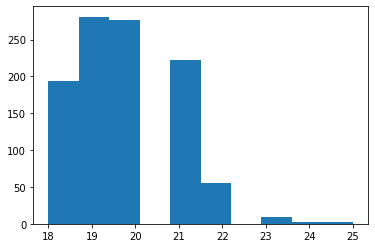

In [ ]:
# Shifting age
if min(raw_data.age) < 18:
  raw_data.age = raw_data.age + 3
plt.hist(raw_data.age)

Now we're going to create a simulated feature representing students who drop out. It's a binary feature, one or zero, but we're going to draw it from `grade_final`, which is continuous. To do this we need to find some value in `grade_final` below which the desired number of students fall for which we can apply a `1` representing dropout. We'll shoot for a 20–35% dropout rate. Note: this is not intended to be a first year retention rate.

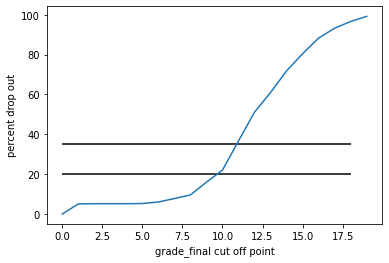

In [ ]:
# Figuring out where to draw cut off point to simulate drop out feature 
x = range(raw_data.grade_final.max())

y = [len(raw_data[raw_data.grade_final < cut_off_point]) / len(raw_data) * 100 for 
     cut_off_point in range(raw_data.grade_final.max())]

plt.plot(x, y)
plt.ylabel('percent drop out')
plt.xlabel('grade_final cut off point')
plt.hlines(y=(20,35), xmin=0, xmax=18)
plt.show()

In [ ]:
# Creating new variable simulating 22% dropout rate based on low
# performance on final grade
raw_data['dropout'] = raw_data.grade_final
raw_data.loc[raw_data.dropout < 10, 'dropout'] = 1
raw_data.loc[raw_data.dropout >= 10, 'dropout'] = 0
raw_data.dropout.unique()
print(raw_data.dropout.value_counts())
print('\n', '{:.1%} dropout rate'.format(raw_data.dropout.sum()/len(raw_data)))

0    814
1    230
Name: dropout, dtype: int64

 22.0% dropout rate


In [ ]:
# Testing for how closely correlated the grade variables are
raw_data[['grade_first', 'grade_second', 'grade_final']].corr()

,grade_first,grade_second,grade_final
grade_first,1.000000,0.858739,0.809142
grade_second,0.858739,1.000000,0.910743
grade_final,0.809142,0.910743,1.000000


We know we won't be running models on `grade_final` since our engineered target variable, `dropout`, is derived from it. We can also see that `grade_first` and `grade_second` are highly correlated with `grade_final`, so we won't be using those, either. We can go ahead and drop these features.

In [ ]:
# Possible to replace 'set([---])' with '{---}'.
if set(['grade_first', 'grade_second', 'grade_final']).issubset(raw_data.columns):
  raw_data.drop(columns=['grade_first', 'grade_second', 'grade_final'],
                inplace=True)

# Missing Values and Outliers 

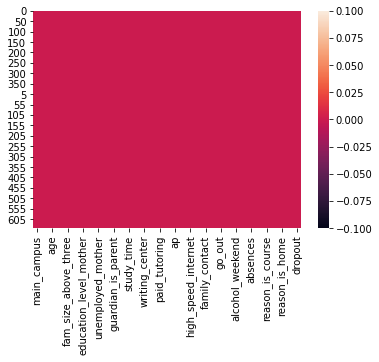

In [ ]:
# We can see from this heatmap that there are no missing values in
# this dataset.
sns.heatmap(raw_data.isnull())

Since there are no missing values in the data, in order to simulate dealing with missing values, we need to insert them artificially. Testing creating a random percent for each column null percentage. Final figure estimates the average percent of nulls for the columns a given definition of the standard deviation of random.gauss will produce.

In [ ]:
# Defining standard distribution for random scalar selection from
# normal distribution
std_dev = .03

# Adding 1000 random values to 'mean_list'
mean_list = []

for i in range(1000):
  # Taking random values from normal distribution with a standard deviation
  # of 0.05 (5%)
  rand_percent = abs(random.gauss(0, std_dev))
  mean_list.append(rand_percent)

print('{:.1%} of values are missing'.format(sum(mean_list) / len(mean_list)))

2.4% of values are missing


Below, we're randomly identifying a random percent of values in each column dervied from the absolute value of a gaussian distribution with a standard deviation at .04, or what will be 4% null. These selected values are assigned `nan`. This is a way of simulating to some degree the randomness in terms of how many nulls are in a column and where they are in the column of nulls in a dataset with natural missing values.

['paid_tutoring', 0.13]
['reason_is_home', 0.13]
['ap', 0.12]
['male', 0.11]
['guardian_is_parent', 0.11]
['education_level_father', 0.1]
['failures', 0.1]
['romantic', 0.09]
['study_time', 0.07]
['activities', 0.06]
['on_campus', 0.05]
['share_household', 0.05]
['school_tutoring', 0.05]
['high_speed_internet', 0.04]
['alcohol_weekend', 0.04]
['education_level_mother', 0.03]
['travel_time', 0.03]
['writing_center', 0.03]
['grad_school', 0.03]
['go_out', 0.03]
['family_contact', 0.02]
['reason_is_other', 0.02]
['fam_size_above_three', 0.01]
['unemployed_father', 0.01]
['free_time', 0.01]
['alcohol_weekday', 0.01]
['health', 0.01]
['absences', 0.01]
['reason_is_course', 0.01]
['reason_is_reputation', 0.01]
['main_campus', 0.0]
['age', 0.0]
['unemployed_mother', 0.0]
['ba', 0.0]
['dropout', 0.0]

 4.3% of values are missing 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


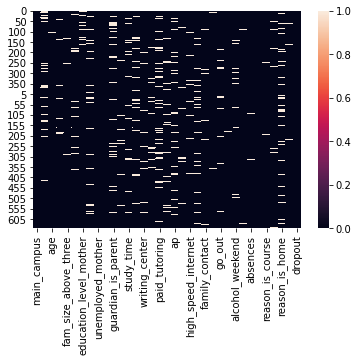

In [ ]:
nulled_data = raw_data.copy()

# Processing df copy column by column. Absenting critical identifying
# information and the target variable.
skip_cols = ['ba', 'main_campus', 'dropout']

# Using list comprehension in combination with for loop to select for
# particular columns I want to operate on.
for col in [col for col in nulled_data.columns if col not in skip_cols]:

    # Generating percent figure from the absolute value of a Guassian
    # distribution with a standard deviation at .04
    rand_percent = abs(random.gauss(0, .04))

    # Randomly sampling that percentage from the given column and assigning
    # nan to those values
    nulled_data.loc[nulled_data.sample(frac=rand_percent).index, col] = pd.np.nan

# Calculuating missing values as percent of each column
col_nulls = []
for col in nulled_data.columns:
  percent_null = nulled_data[col].isnull().sum() / len(nulled_data)
  col_nulls.append([col, round(percent_null, 2)])

# Row-null percentage pairs are appended to list so that it can be sorted
# (below) and displayed in descending order. (Can also use operator.itemgetter
# here for faster code)
col_nulls.sort(key=lambda x: x[1],
               reverse=True)
for pair in col_nulls:
  print(pair)

# Visualizing nulls 
print("\n", "{:.1%} of values are missing".format(nulled_data.isnull().sum().sum() / 
                      (nulled_data.shape[0] * 
                       nulled_data.shape[1])),
      "\n")   
sns.heatmap(nulled_data.isnull())

In [ ]:
# Trying dropping all rows with more than 6 missing values. Is using dropna()
# with the thresh parameter more efficient here?
dropped_data = nulled_data[nulled_data.isnull().sum(axis=1) < 5]

ratio_rows = 1 - len(dropped_data) / len(nulled_data)
ratio_nulls = 1 - dropped_data.isnull().sum().sum() / nulled_data.isnull().sum().sum()

print("For dropping {:.1%} of rows, it's possible to drop {:.1%} of missing values.".format(ratio_rows, ratio_nulls))

For dropping 2.8% of rows, it's possible to drop 10.0% of missing values.


This seems like a good deal. It could be for the models where we're not focusing closely on a small number of features, these particular rows where a lot of values are imputed or interpolated could add noise.


 4.0% of values are missing 



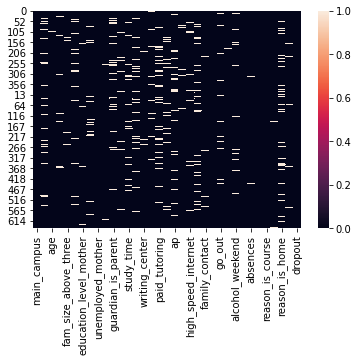

In [ ]:
# Setting nulled_data equal to df with rows dropped with six or more
# missing values
nulled_data = dropped_data.copy()

# Visualizing nulls 
print("\n", "{:.1%} of values are missing".format(nulled_data.isnull().sum().sum() / 
                      (nulled_data.shape[0] * 
                       nulled_data.shape[1])),
      "\n")   
sns.heatmap(nulled_data.isnull())

Now we'll implement rounded mean imputation for the whole dataframe broken into four groups according to campus (main and downtown, 1 or 0, and BA or BS, 1 or 0).

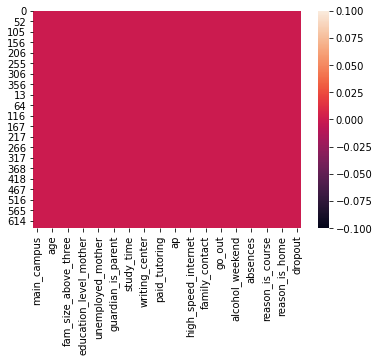

In [ ]:
# Using product from itertools to break the df into four groups and imputing
# mean value for each group
for campus, degree in itertools.product([1, 0], [1, 0]):
    group = (nulled_data.main_campus == campus) & (nulled_data.ba == degree)
    group_mean = round(nulled_data.loc[group, :].mean())
    nulled_data.loc[group, :] = nulled_data.loc[group, :].fillna(group_mean)

sns.heatmap(nulled_data.isnull())

Now we'll need to deal with any outliers. Since `absences` is the only explanatory feature that really behaves like a continuous variable (we won't be using the grade features in the modeling), we'll just check for outliers there.

{'boxes': [<matplotlib.lines.Line2D at 0x7ff259badc50>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff259bb46d8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff259bb4b38>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff259bb4b00>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff259badb38>,
  <matplotlib.lines.Line2D at 0x7ff259bad860>]}

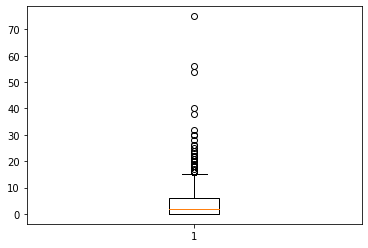

In [ ]:
plt.boxplot(nulled_data.absences.dropna())

{'boxes': [<matplotlib.lines.Line2D at 0x7ff259a60160>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff2599b3470>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff2598a5128>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff2599b3828>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff25995f4e0>,
  <matplotlib.lines.Line2D at 0x7ff259955a58>]}

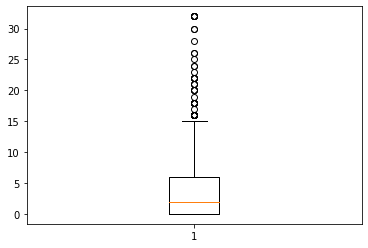

In [ ]:
# Using winsorization to reset the top five outliers into
# the 30–40 range
for series in [nulled_data.absences, raw_data.absences]:
  series = mstats.winsorize(series, limits=(0,.005), inplace=True)
plt.boxplot(series)

# Exploring Features

In [ ]:
# sns.set(font_scale=3)
# plt.figure(figsize=(10,13))
# ax = sns.barplot(x=['Graduates',
#                     'Dropouts'],
#                  y=[val for val in nulled_data.dropout.value_counts()]
#                  ).set(title='Graduates Compared with Dropouts',
#                        ylabel='Number of Students')

In [ ]:
# sns.set(font_scale=3)
# plt.figure(figsize=(10,13))
# ax = sns.barplot(x=['Downtown',
#                     'Main'],
#                  y=[val for val in nulled_data.dropout.value_counts()]
#                  ).set(title='Graduates Compared with Dropouts',
#                        ylabel='Number of Students')

In [ ]:
# sns.set(font_scale=3)
# plt.figure(figsize=(10,12))

# sns.countplot(x='ba', hue='dropout', data=nulled_data
#               ).set(title='Dropouts by Degree Type',
#                     ylabel='Number of Students',
#                     xlabel='Degree Type',
#                     xticklabels=['B.S.', 'B.A.'])
# plt.legend(labels = ['Graduates', 'Dropouts'],
#            loc = 2,
#            title = None)

In [ ]:
# nulled_data['drinks_on_weekdays'] = (
#     nulled_data.alcohol_weekday.apply(lambda x: 1 if x == 1 else 0)
# )

# sns.set(font_scale=3)
# plt.figure(figsize=(10,12))

# sns.countplot(x='drinks_on_weekdays', hue='dropout', data=nulled_data
#               ).set(title='Dropouts by Alcohol',
#                     ylabel='Number of Students',
#                     xlabel='Drinks on Weekdays',
#                     xticklabels=['Yes', 'No'])
# plt.legend(labels = ['Graduates', 'Dropouts'],
#            loc = 2,
#            title = None)

# nulled_data = nulled_data.drop(columns=['drinks_on_weekdays'])

In [ ]:
# sns.set(font_scale=3)
# plt.figure(figsize=(10,12))

# sns.countplot(x='ap', hue='dropout', data=nulled_data
#               ).set(title='Dropouts by Whether Student has AP Credit',
#                     ylabel='Number of Students',
#                     xlabel='AP Credit',
#                     xticklabels=['No', 'Yes'])
# plt.legend(labels = ['Graduates', 'Dropouts'],
#            loc = 2,
#            title = None)

In [ ]:
# Getting ratios of dropouts for selected variables

# Recreating 'drinks_on_weekdays' feature
nulled_data['drinks_on_weekdays'] = (
    nulled_data.alcohol_weekday.apply(lambda x: 0 if x == 1 else 1)
)


for var in ['main_campus', 'ba', 'ap', 'drinks_on_weekdays']:

  avg_dropout_ratio = nulled_data.dropout.sum() / len(nulled_data)

  filter_pos = nulled_data.dropout[nulled_data[var].astype(bool)]
  filter_neg = nulled_data.dropout[~nulled_data[var].astype(bool)]

  for filter in [filter_pos, filter_neg]:
      percent_diff = avg_dropout_ratio - filter.sum() / len(filter)
      printable = '{} = {}: {:.1%}'.format(var, 0, percent_diff)
      print(printable)

# Dropping 'drinks_on_weekdays' feature
nulled_data = nulled_data.drop(columns=['drinks_on_weekdays'])

main_campus = 0: 3.4%
main_campus = 0: -9.3%
ba = 0: 6.6%
ba = 0: -11.0%
ap = 0: 0.0%
ap = 0: -0.0%
drinks_on_weekdays = 0: -5.9%
drinks_on_weekdays = 0: 2.5%


# Setting up train test splits

It's worth noting that we'll preserve both forms of the dataset, `raw_data` and `nulled_data`, so that we can compare model performance on the original dataset without missing values, and on the data frame with nulled and imputed values. Ideally we could have a couple differnet methods of filling in the missing values that we could compare with `raw_data`, but due to the fact that all but one of the variables are categorical, we currently have only one methodology for filling in missing vales, `nulled_data`. It may be interesting to compare model results with other dataframes that have values imputed based on whole columns rather than columns divided by `school` and `subject`, or one where the variable mode is imputed rather than the rounded variable mean.

In [ ]:
# Standard train test split

scaler = StandardScaler()

X = nulled_data.drop(columns=['dropout'], axis=1)
scaler.fit(X)
scaled_X = scaler.transform(X)
y = nulled_data.dropout

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=.8,
                                                    random_state=42)


scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = (
    train_test_split(scaled_X, y,
                     train_size=.8,
                     random_state=42)
)

In [ ]:
# Train test split for raw data

raw_X = raw_data.drop(columns=['dropout'], axis=1)
scaler.fit(raw_X)
scaled_raw_X = scaler.transform(raw_X)
raw_y = raw_data.dropout

raw_X_train, raw_X_test, raw_y_train, raw_y_test = (
    train_test_split(raw_X, raw_y,
    train_size=.8,
    random_state=42)
)

# Defining Functions

In [ ]:
class get_results():

  def __init__():
  
  def scores_and_metrics():

  def visualize_feature_importances():

  def show_confusion_matrix():

  def plot_ROC():

In [ ]:
def scores_and_metrics(model, preds, X_train, y_train, cv, y_test):

    start_time = time.time()

    cv_scores = cross_val_score(model, X_train, y_train, cv = cv)
    print('Cross validation scores: {}%'.format(round(cv_scores.mean() * 100, 2)), cv_scores, '\n')

    print(metrics.classification_report(y_test, preds))

    print("Cross-validation in %s seconds." % (round(time.time() - start_time, 3)))

In [ ]:
# Loading coefficients with feature labels into pandas dataframe
def visualize_feature_importances(feature_set,
                                  model,
                                  importances,
                                  feature_names=X.columns):

    importances_list = [val.item() for
                        val in np.reshape(importances, (feature_set.shape[1],1))]

    coefficients_df = pd.DataFrame(zip(feature_names, importances_list)
                                  ).sort_values(by=1)

    plt.figure(figsize=(12,8))
    plt.barh(y = coefficients_df[0],
             width = coefficients_df[1])
    plt.title('Absolute value of coefficients/importances')
    plt.style.use(['dark_background'])
    plt.show()

    abs_importances_list = [abs(val.item()) for
                            val in np.reshape(importances,
                                              (feature_set.shape[1],1))
                            ]

    # Printing importances by absolute value
    print(pd.DataFrame(zip(feature_names, abs_importances_list)
                                  ).sort_values(by=1, ascending=False))

In [ ]:
# Creating a function for a confusion matrix
def show_confusion_matrix(y_test, preds, target_names, normalize=False):

    cm = metrics.confusion_matrix(y_test, preds)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
def plot_ROC(model, X_test=X_test, y_test=y_test):
    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
nulled_data.dropout.sum() / len(nulled_data)

0.2206896551724138

# Logistic Regression

## Nonregularized Logistic (Nonstandardized)

Cross validation scores: 79.06% [0.7607362  0.81595092 0.77777778 0.80246914 0.7962963 ] 

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       157
           1       0.75      0.26      0.39        46

    accuracy                           0.81       203
   macro avg       0.78      0.62      0.64       203
weighted avg       0.80      0.81      0.78       203

Cross-validation in 0.759 seconds.


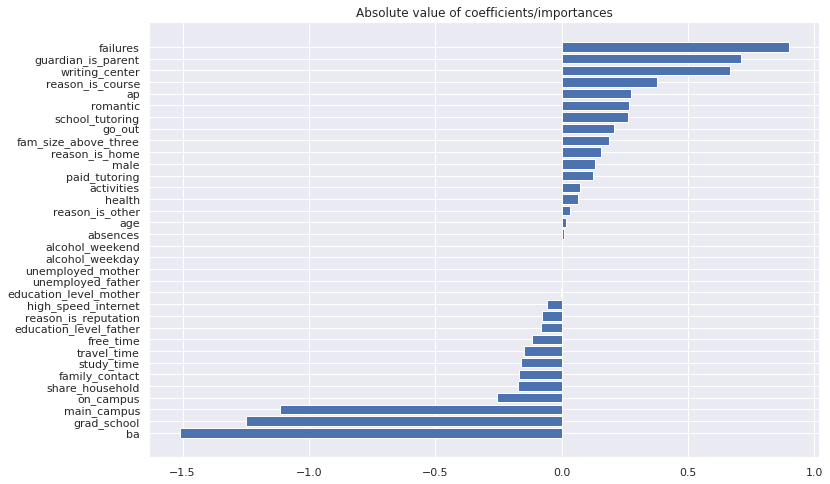

                         0         1
29                      ba  1.510419
19             grad_school  1.250513
0              main_campus  1.115227
13                failures  0.898413
10      guardian_is_parent  0.710448
14          writing_center  0.665495
30        reason_is_course  0.375839
18                      ap  0.273852
21                romantic  0.266920
15         school_tutoring  0.261678
3                on_campus  0.254781
24                  go_out  0.205780
4     fam_size_above_three  0.189458
5          share_household  0.171472
22          family_contact  0.167915
12              study_time  0.162484
32          reason_is_home  0.155766
11             travel_time  0.150600
1                     male  0.134124
16           paid_tutoring  0.122722
23               free_time  0.117612
7   education_level_father  0.082063
33    reason_is_reputation  0.077614
17              activities  0.074079
27                  health  0.064313
20     high_speed_internet  0.058537
3

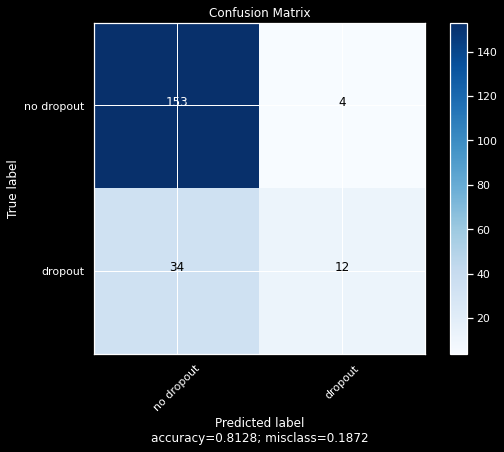

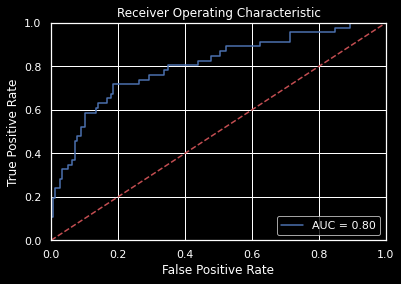

In [ ]:
# Instantiating a Logistic Regression classifier with a
# lbfgs solver and penalty set to 'none'.
lr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='none')
lr.fit(X_train, y_train)
preds = lr.predict(X_test)
cv = 5

sns.set(font_scale=1)
scores_and_metrics(lr, preds, X_train, y_train, cv, y_test)
visualize_feature_importances(X, lr, lr.coef_)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])
plot_ROC(lr)

## Ridge Regularization (Nonstandardized)

Cross validation scores: 79.06% [0.7607362  0.81595092 0.78395062 0.80246914 0.79012346] 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       157
           1       0.80      0.26      0.39        46

    accuracy                           0.82       203
   macro avg       0.81      0.62      0.64       203
weighted avg       0.81      0.82      0.78       203

Cross-validation in 0.557 seconds.


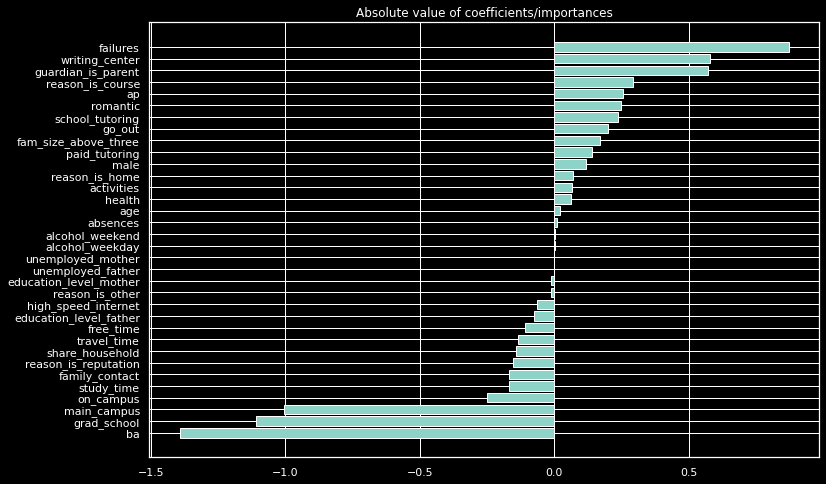

                         0         1
29                      ba  1.391805
19             grad_school  1.109530
0              main_campus  1.005867
13                failures  0.871860
14          writing_center  0.578595
10      guardian_is_parent  0.571661
30        reason_is_course  0.294563
18                      ap  0.256205
3                on_campus  0.251074
21                romantic  0.247594
15         school_tutoring  0.236493
24                  go_out  0.199448
4     fam_size_above_three  0.171781
12              study_time  0.166564
22          family_contact  0.166509
33    reason_is_reputation  0.151610
5          share_household  0.143337
16           paid_tutoring  0.140811
11             travel_time  0.135481
1                     male  0.119977
23               free_time  0.108247
7   education_level_father  0.073577
32          reason_is_home  0.070152
17              activities  0.067364
20     high_speed_internet  0.064343
27                  health  0.061910
2

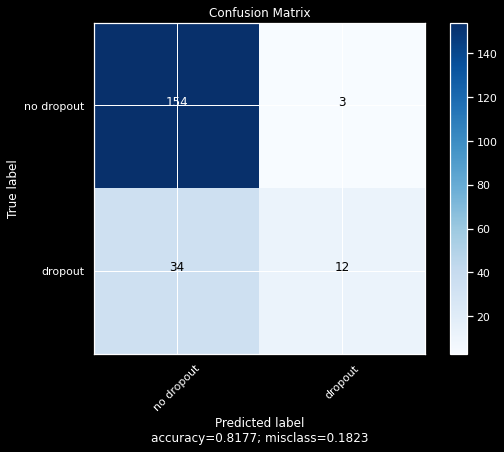

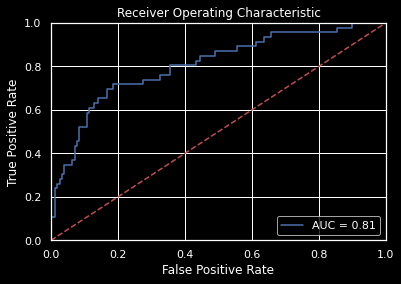

In [ ]:
# Now setting penalty to l2 (ridge).
ridgeregr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2')
ridgeregr.fit(X_train, y_train)
preds = ridgeregr.predict(X_test)
cv = 5

scores_and_metrics(ridgeregr, preds, X_train, y_train, cv, y_test)
visualize_feature_importances(X, ridgeregr, ridgeregr.coef_)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])
plot_ROC(ridgeregr)

## Lasso Regularization (Nonstandardized)

Cross validation scores: 79.06% [0.7607362  0.81595092 0.78395062 0.80246914 0.79012346] 

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       157
           1       0.80      0.26      0.39        46

    accuracy                           0.82       203
   macro avg       0.81      0.62      0.64       203
weighted avg       0.81      0.82      0.78       203

Cross-validation in 0.517 seconds.


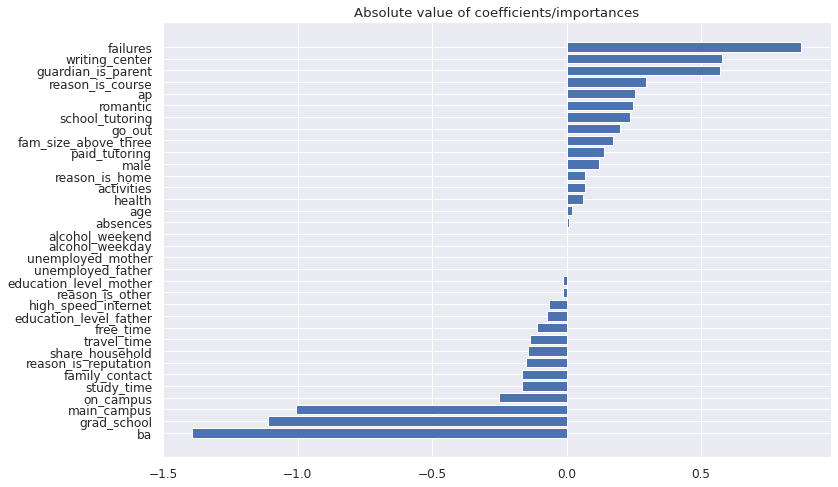

                         0         1
29                      ba  1.391805
19             grad_school  1.109530
0              main_campus  1.005867
13                failures  0.871860
14          writing_center  0.578595
10      guardian_is_parent  0.571661
30        reason_is_course  0.294563
18                      ap  0.256205
3                on_campus  0.251074
21                romantic  0.247594
15         school_tutoring  0.236493
24                  go_out  0.199448
4     fam_size_above_three  0.171781
12              study_time  0.166564
22          family_contact  0.166509
33    reason_is_reputation  0.151610
5          share_household  0.143337
16           paid_tutoring  0.140811
11             travel_time  0.135481
1                     male  0.119977
23               free_time  0.108247
7   education_level_father  0.073577
32          reason_is_home  0.070152
17              activities  0.067364
20     high_speed_internet  0.064343
27                  health  0.061910
2

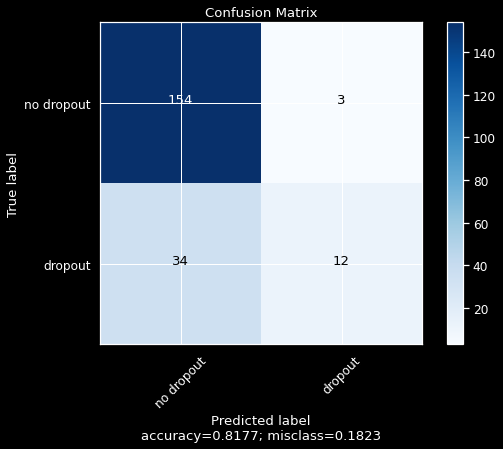

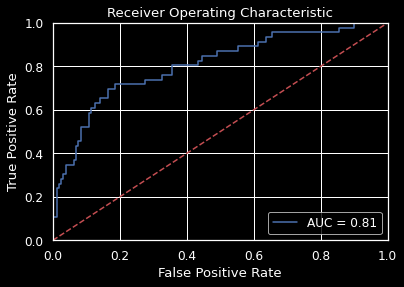

In [ ]:
# Now setting penalty to l1 (Lasso).
lassoregr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2')
lassoregr.fit(X_train, y_train)
preds = lassoregr.predict(X_test)
cv = 5

scores_and_metrics(lassoregr, preds, X_train, y_train, cv, y_test)
sns.set(font_scale=1.1)
visualize_feature_importances(X, lassoregr, lassoregr.coef_)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])
plot_ROC(lassoregr)

In [ ]:
np.exp(1.39)

4.014850052994201

The results for all three models are very similar, but ridge is a little faster. Let's see if GridSearchCV selects the same penalizer.

In [ ]:
nulled_data.dropout.sum() / len(nulled_data)

0.2206896551724138

## Grid Search (Standardized)

In [ ]:
# Suppressing fail fit warning due to incompatible hyperparameters
%%capture
# Setting parameters for 'params' GridSearchCV parameter
params= {'solver': ('lbfgs', 'liblinear'),
         'penalty': ('none', 'l2', 'l1')}

gscv = GridSearchCV(estimator=LogisticRegression(max_iter=1000),
                    param_grid=params,
                    n_jobs=None,
                    cv=5,
                    return_train_score=True)
gscv.fit(scaled_X_train, y_train)

In [ ]:
print('The best penalty hyperparameter is', gscv.best_params_['penalty'])
print('Best score: {0:.0%}'.format(gscv.best_score_))
print("Time to fit model: ", round(gscv.refit_time_, 3), 'seconds')

The best penalty hyperparameter is l1
Best score: 79%
Time to fit model:  0.007 seconds


Grid Search confirms Lasso is the preferred penalizer, and the model can converge under 500 interations. Now we'll run Lasso on the standardized data. The none of the logistic regression models perform as well on the standardized data, but we'll need the results in order to get accurate feature coefficients.

## Lasso Regression (Standardized)

Cross validation scores: 79.06% [0.7607362  0.81595092 0.78395062 0.80246914 0.79012346] 

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       157
           1       0.75      0.26      0.39        46

    accuracy                           0.81       203
   macro avg       0.78      0.62      0.64       203
weighted avg       0.80      0.81      0.78       203

Cross-validation in 0.605 seconds.


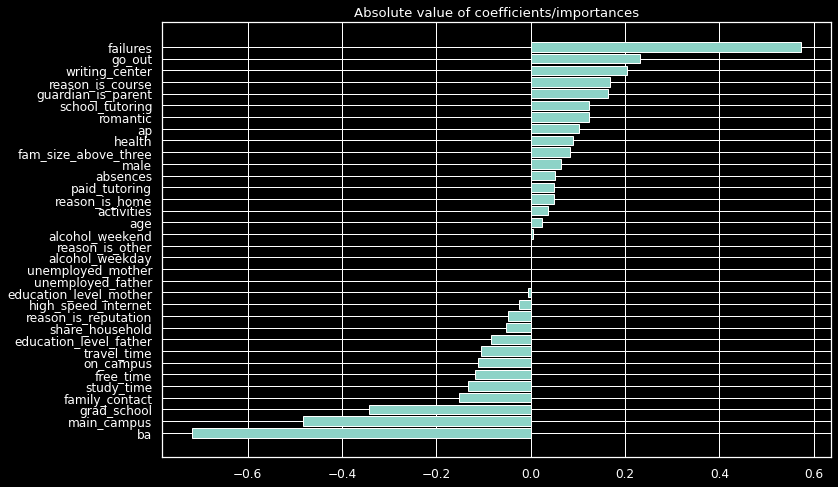

                         0         1
29                      ba  0.717173
13                failures  0.572940
0              main_campus  0.482174
19             grad_school  0.341920
24                  go_out  0.231236
14          writing_center  0.203614
30        reason_is_course  0.167133
10      guardian_is_parent  0.164802
22          family_contact  0.152289
12              study_time  0.131850
15         school_tutoring  0.123908
21                romantic  0.123395
23               free_time  0.117659
3                on_campus  0.112049
11             travel_time  0.105962
18                      ap  0.103294
27                  health  0.089689
4     fam_size_above_three  0.084149
7   education_level_father  0.083720
1                     male  0.063544
5          share_household  0.052612
28                absences  0.052435
16           paid_tutoring  0.050308
32          reason_is_home  0.049440
33    reason_is_reputation  0.047660
17              activities  0.036307
2

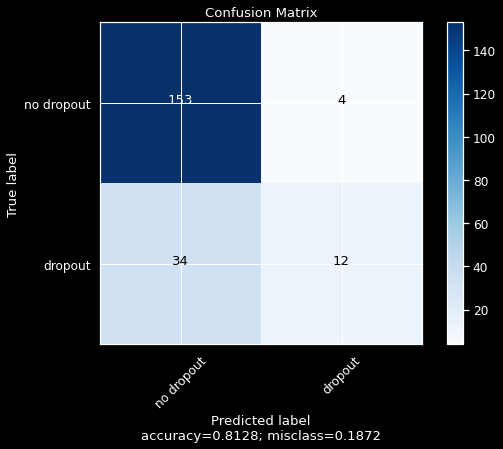

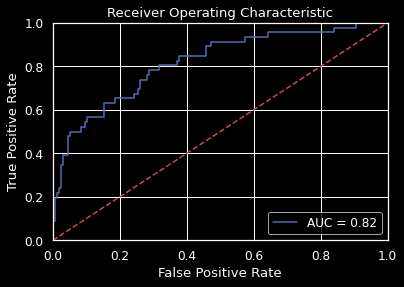

In [ ]:
# Now setting penalty to l1 (Lasso).
lassoregr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2')
lassoregr.fit(scaled_X_train, scaled_y_train)
preds = lassoregr.predict(scaled_X_test)
cv = 5

scores_and_metrics(lassoregr, preds, X_train, y_train, cv, y_test)
visualize_feature_importances(X, lassoregr, lassoregr.coef_)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])
plot_ROC(lassoregr)

In [ ]:
# Finding feature importances by multiplying coefficients by
# the standard deviation of the corresponding feature

importances_list = [val.item() for
                    val in np.reshape(lassoregr.coef_,
                                      (scaled_X.shape[1],1))
                    ]

st_devs = [statistics.stdev(nulled_data[col]) for col in X.columns]

coefficients_df = pd.DataFrame(zip(X.columns, importances_list, st_devs
                               )).sort_values(by=1)
coefficients_df.columns = ['var', 'coef', 'stdev']
coefficients_df['importance'] = coefficients_df.coef * coefficients_df.stdev
coefficients_df = coefficients_df.sort_values(by='importance', ascending=False)
coefficients_df.set_index('var', inplace=True)
largest_coefficients_df = (
    coefficients_df.loc[['absences',
                         'failures',
                         'go_out',
                         'main_campus',
                         'alcohol_weekend',
                         'education_level_father',
                         'ba'], :]
)

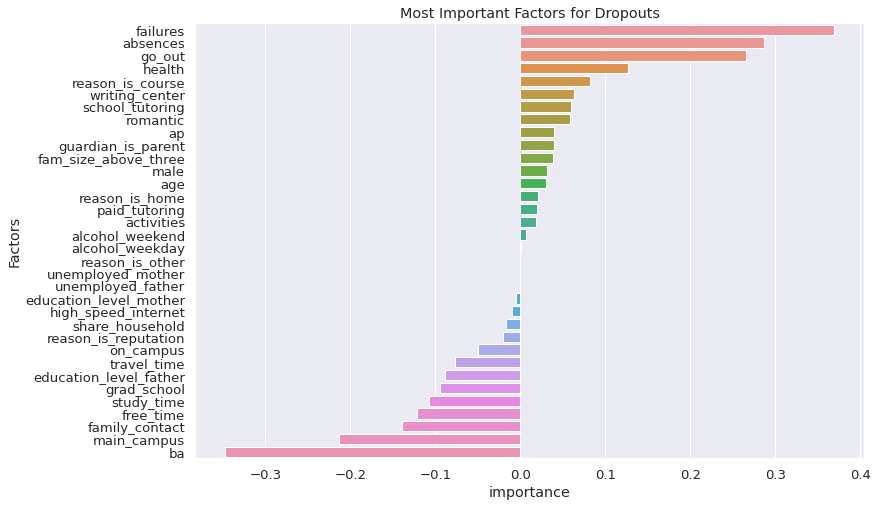

In [ ]:
sns.set(font_scale=1.2)
plt.figure(figsize=(12,8))
ax = sns.barplot(y = coefficients_df.index,
                 x = coefficients_df['importance'])
plt.title('Most Important Factors for Dropouts')
ax.set_ylabel('Factors')
plt.show()

In [ ]:
largest_coefficients_df.index

Index(['absences', 'failures', 'go_out', 'main_campus', 'alcohol_weekend',
       'education_level_father', 'ba'],
      dtype='object', name='var')

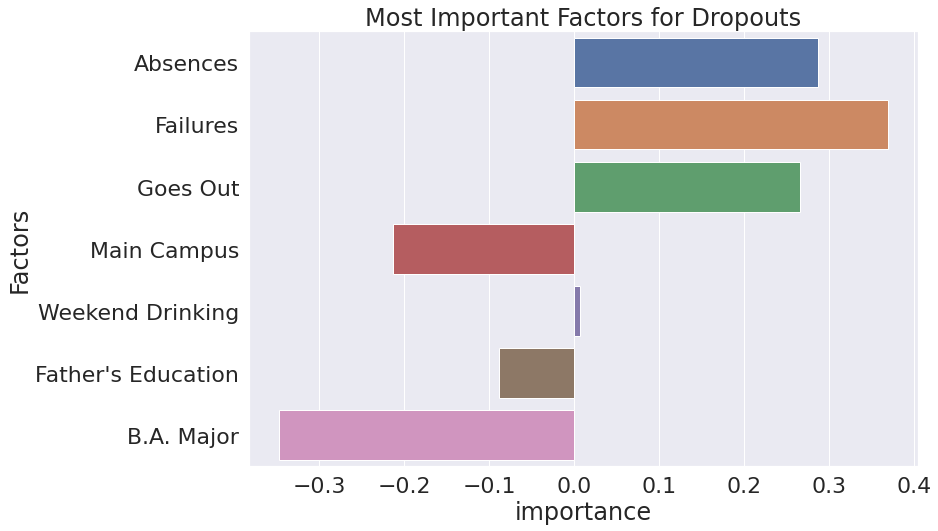

In [ ]:
sns.set(font_scale=2)
plt.figure(figsize=(12,8))
ax = sns.barplot(y = largest_coefficients_df.index,
            x = largest_coefficients_df['importance'])
plt.title('Most Important Factors for Dropouts')
ax.set_yticklabels(
    ['Absences', 'Failures', 'Goes Out', 'Main Campus',
     'Weekend Drinking', 'Father\'s Education', 'B.A. Major'])
ax.set_ylabel('Factors')
plt.show()

## Lasso Regression on Raw Data

Now we'll compare the performance of lasso regression, our best estimator, with the data that wasnt imputed in order to see how much information was lost in the introduction and replacement of missing data.

Cross validation scores: 82.28% [0.83233533 0.8502994  0.77245509 0.82634731 0.83233533] 

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       149
           1       0.61      0.28      0.39        60

    accuracy                           0.74       209
   macro avg       0.68      0.60      0.61       209
weighted avg       0.72      0.74      0.71       209

Cross-validation in 0.529 seconds.


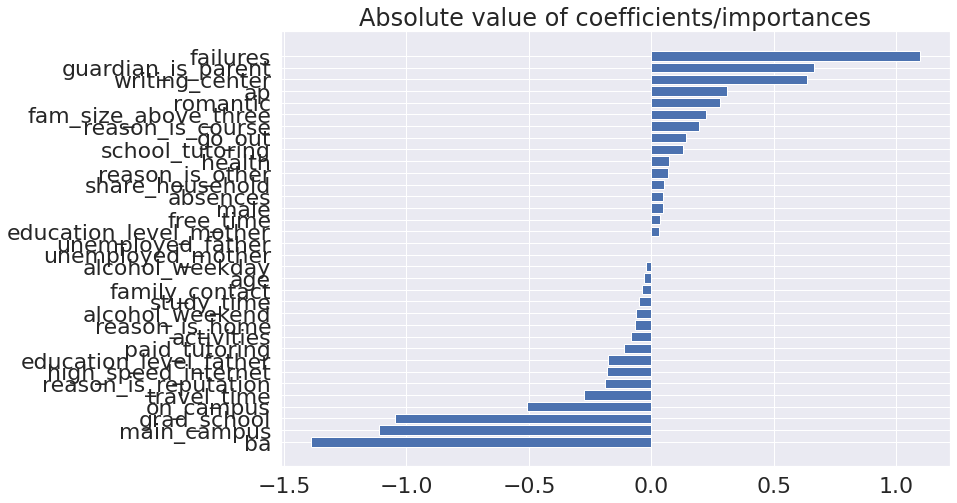

                         0         1
29                      ba  1.389685
0              main_campus  1.113598
13                failures  1.095497
19             grad_school  1.046765
10      guardian_is_parent  0.665179
14          writing_center  0.636108
3                on_campus  0.508729
18                      ap  0.307974
21                romantic  0.281618
11             travel_time  0.273262
4     fam_size_above_three  0.221978
30        reason_is_course  0.194695
33    reason_is_reputation  0.191303
20     high_speed_internet  0.181747
7   education_level_father  0.178027
24                  go_out  0.142274
15         school_tutoring  0.128072
16           paid_tutoring  0.112192
17              activities  0.082318
27                  health  0.072753
31         reason_is_other  0.069211
32          reason_is_home  0.067712
26         alcohol_weekend  0.064159
5          share_household  0.051688
12              study_time  0.050957
28                absences  0.048135
1

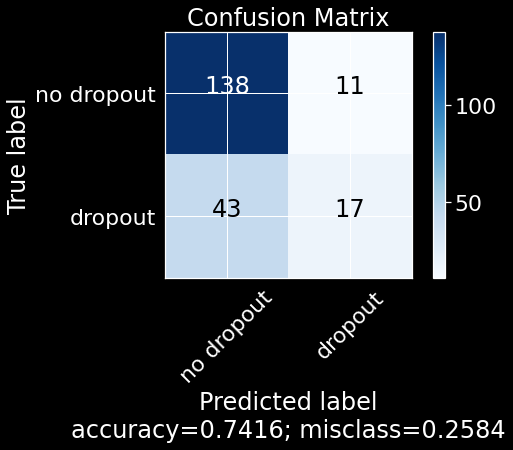

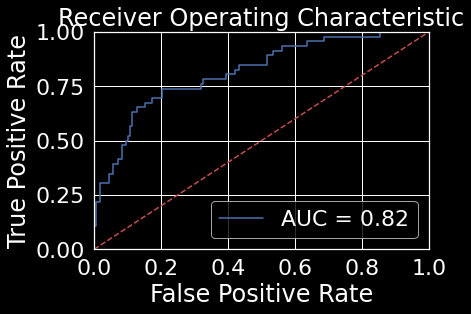

In [ ]:
# Now setting penalty to l2 (Ridge) on raw data.
lassoregr = LogisticRegression(solver='lbfgs', max_iter=1000, penalty='l2')
lassoregr.fit(raw_X_train, raw_y_train)
preds = lassoregr.predict(raw_X_test)
cv = 5

scores_and_metrics(lassoregr, preds, raw_X_train, raw_y_train, cv, raw_y_test)
visualize_feature_importances(X, lassoregr, lassoregr.coef_)
show_confusion_matrix(raw_y_test, preds, ['no dropout', 'dropout'])
plot_ROC(lassoregr)

* The mean cross validation score was only 0.3% higher.
* We see fewer true negatives, but many more true positives. There's one extra false positive (type I error) (corresponding to the loss of one point of recall for nondropout/negative), and 9 fewer fallse negatives (type II errors).
* Therefore when switching to the raw data, we see a 7 point increase in precision, but a 17 point increase in recall. It appears the increase in precision is due to just correctly identifying more dropouts, but in addition to that the switch to raw data allows the model to also not miss as many dropouts (miscategorizing dropouts as non-dropouts).
* Put simply, recall (failing to identify dropouts) suffers the most from the process of removing values and imputing new ones.
* Most importantly, perhaps, we see a dramatic change in which features are considered most influential.

# Feature Selection

Regularized and nonregularized regression selects the same six top features, and Ridge and Lasso selects them with the same order of importance.

It's notable that nonregularized regression run on the raw nonimputed data saw `failures` as the significantly more significant features, compared to `grad_school` which came in second. It also introduced `guardian_is_parent` into the top six at the expense of `reason_is_course`. However, since this is just for theoretical awareness, we won't include this information in the next iteration.

We'll select features that our best estimator, Lasso, selected as having the highest coefficients. The selection of six features is somewhat arbitrary in this case, since there's no sharp drop off in feature importance, and ideally we will run the model several times on different feature sets to prevent overfitting.

## Running Grid Search on Selected Features

Now we'll run Grid Search again on just these selected features and see if Lasso is still the best performer and if accuracy is improved with the best model.

In [ ]:
num_top_coefs = 7

lassoregr.fit(X_train, y_train)

# Taking absolute values of coefficients since it's our goal to select
# features of greatest importance
importances_list = [abs(val.item()) for
                    val in
                    np.reshape(lassoregr.coef_,
                               (len(X.columns),1))
                    ]

# Zipping coefficients to feature names to identify largest coefficients
coefficients_df = pd.DataFrame(zip(X.columns, importances_list)
                                  ).sort_values(by=1, ascending=False)

# Stripping top six coefficients to list
top_coefs = [coef for coef in coefficients_df.iloc[:num_top_coefs, 0]]

# Creating new X feature set and split with top 6 features
selected_X = nulled_data[top_coefs]
selected_X_train, selected_X_test, y_train, y_test = (
    train_test_split(selected_X,
                     y,
                     train_size=.8,
                     random_state=42)
)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)


The best penalty hyperparameter is l2
Best score: 80%
Time to fit model:  0.007 seconds
Cross validation scores: 80.18% [0.76687117 0.80981595 0.80246914 0.82716049 0.80246914] 

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       157
           1       0.78      0.15      0.25        46

    accuracy                           0.80       203
   macro avg       0.79      0.57      0.57       203
weighted avg       0.79      0.80      0.74       203

Cross-validation in 0.063 seconds.


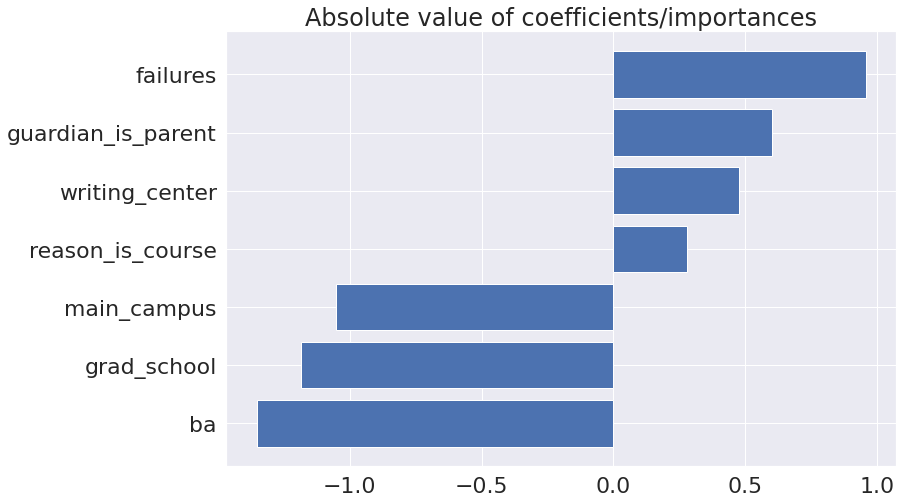

                    0         1
0                  ba  1.351849
1         grad_school  1.183972
2         main_campus  1.051411
3            failures  0.956152
5  guardian_is_parent  0.599448
4      writing_center  0.477543
6    reason_is_course  0.277620


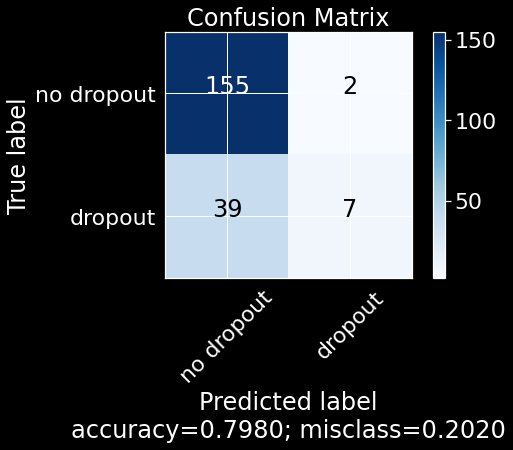

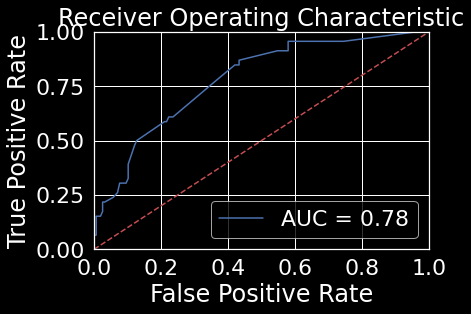

In [ ]:
# Running grid search

gscv.fit(selected_X_train, y_train)
preds = gscv.predict(selected_X_test)
cv = 5

print('The best penalty hyperparameter is', gscv.best_params_['penalty'])
print('Best score: {0:.0%}'.format(gscv.best_score_))
print("Time to fit model: ", round(gscv.refit_time_, 3), 'seconds')

best_estimator = gscv.best_estimator_

scores_and_metrics(best_estimator, preds, selected_X_train, y_train, cv, y_test)
sns.set(font_scale=2)

visualize_feature_importances(selected_X,
                              best_estimator,
                              best_estimator.coef_,
                              feature_names=selected_X.columns)
selected_X.columns
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])
plot_ROC(best_estimator, X_test=selected_X_test)

In [ ]:
importances_list = [val.item() for
                    val in np.reshape(best_estimator.coef_, (selected_X.shape[1],1))]

selected_X.columns

Index(['ba', 'grad_school', 'main_campus', 'failures', 'writing_center',
       'guardian_is_parent', 'reason_is_course'],
      dtype='object')

* Precision and recall are not improved by running logistic regression with no penalty on the selected feature set, and Lasso runs 5% faster.
* Compared to Lasso run on the full feature set on my final run of this code (nulls are reset each time, so each full run on the code can produce slightly different results), Lasso run on the reduced set:
  * Improved precision by 1.3%
  * Reduced recall by 12.8%
  * Improved the cross validation score by 1.3%
  * Completed in 5.7% of the time, over 17x faster
* Our conclusion is that there's a significant loss of recall that may not be worth it if there's time to run the slower model. However, a reduced feature set remains an option if time is an issue.
* Reducing the feature set to just two features, `grad_school` and `failures`, only adds two more false negatives, and further reduces run time, if run time is a serious issue.2

#### Q: Why do features with such low coefficients seem to have such a strong effect on recall?

# Random Forest and Gradient Boosting

In [ ]:
unscaled_X = nulled_data.drop(columns=['dropout'],
                     axis=1)
unscaled_y = nulled_data.dropout

unscaled_X_train, unscaled_X_test, unscaled_y_train, unscaled_y_test = (
    train_test_split(unscaled_X,
                     unscaled_y,
                     train_size=.8,
                     random_state=42)
)

### First Iteration Random Forest Grid Search

First in developing Random Forest model, we use `GridSearchCV` to tune hyperparameters.

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter
params= {'criterion': ('gini', 'entropy'),
         'max_depth': [4, 6, 8],
         'min_samples_split': [2, 5],
         'min_samples_leaf': [1, 4, 8],
         'bootstrap': (True, False)
         }


rf_gscv = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100,
                                                         random_state=42),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
rf_gscv.fit(unscaled_X_train, unscaled_y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 60.033 seconds ---


--- 0.193 seconds ---
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 5}
Cross validation scores: 80.67% [0.7791411  0.83435583 0.82098765 0.80246914 0.7962963 ] 

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       157
           1       0.67      0.09      0.15        46

    accuracy                           0.78       203
   macro avg       0.73      0.54      0.51       203
weighted avg       0.76      0.78      0.71       203

Cross-validation in 0.818 seconds.


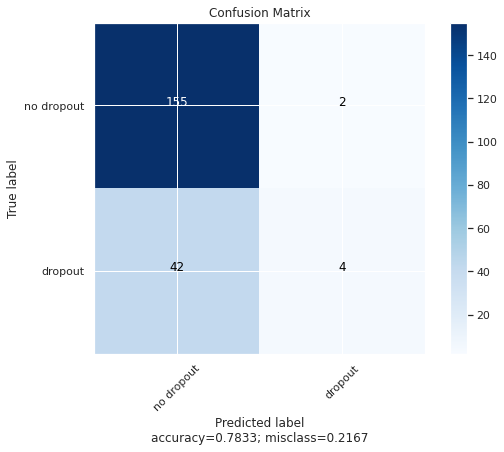

In [ ]:
start_time = time.time()

best_rf_estimator = rf_gscv.best_estimator_
best_rf_estimator.fit(X_train, y_train)

print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

print(rf_gscv.best_params_)
best_estimator = rf_gscv.best_estimator_
preds = best_estimator.predict(unscaled_X_test)
scores_and_metrics(best_estimator, preds, unscaled_X_train, unscaled_y_train, cv, unscaled_y_test)
show_confusion_matrix(unscaled_y_test, preds, ['no dropout', 'dropout'])

Compared with our best logistic regression model:
* Random Forest has 10.4% better precision
* 15.9% worse recall
* 20.3% longer run time

Essentially, we lose ground on our most imporant metric, recall, and the model takes longer. Let's see if it's possible to improve by running random forest on a smaller feature set.

## Random Forest on Reduced Feature Set

In [ ]:
start_time = time.time()

rf_gscv.fit(selected_X_train, y_train)

print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 52.013 seconds ---


{'penalty': 'l2', 'solver': 'lbfgs'}
Cross validation scores: 80.42% [0.80981595 0.80981595 0.77777778 0.81481481 0.80864198] 

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       157
           1       0.64      0.15      0.25        46

    accuracy                           0.79       203
   macro avg       0.72      0.56      0.56       203
weighted avg       0.76      0.79      0.73       203

Cross-validation in 0.615 seconds.


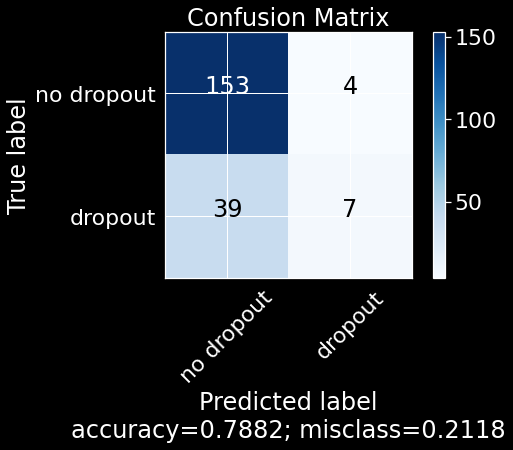

In [ ]:
print(rf_gscv.best_params_)
best_estimator = rf_gscv.best_estimator_
preds = best_estimator.predict(unscaled_X_test)
scores_and_metrics(best_estimator, preds, unscaled_X_train, unscaled_y_train, cv, unscaled_y_test)
show_confusion_matrix(unscaled_y_test, preds, ['no dropout', 'dropout'])

Running random forest on a reduced feature set awards a 30.5% faster run time at the cost of 5.7% drop in precision (but also double recall). The average cross-validation score is about the same.

## Second Iteration Random Forest Grid Search

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter
params= {'max_depth': [14, 16, 20],
         'n_estimators': [10, 30, 50, 75],
         }


rf_gscv = GridSearchCV(estimator=RandomForestClassifier(random_state=42,
                                                        bootstrap=False,
                                                        criterion='entropy',
                                                        min_samples_split=5,
                                                        min_samples_leaf=2),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
rf_gscv.fit(unscaled_X_train, unscaled_y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 5.195 seconds ---


{'max_depth': 16, 'n_estimators': 50}
Cross validation scores: 81.28% [0.7791411  0.83435583 0.82716049 0.83333333 0.79012346] 

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       157
           1       0.69      0.20      0.31        46

    accuracy                           0.80       203
   macro avg       0.75      0.59      0.59       203
weighted avg       0.78      0.80      0.75       203

Cross-validation in 0.486 seconds.


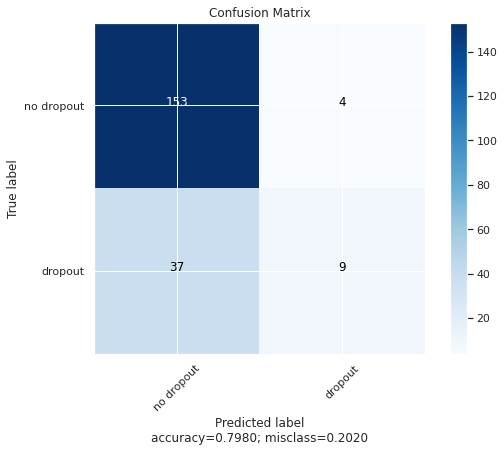

In [ ]:
print(rf_gscv.best_params_)
best_estimator = rf_gscv.best_estimator_
preds = best_estimator.predict(unscaled_X_test)
scores_and_metrics(best_estimator, preds, unscaled_X_train, unscaled_y_train, cv, unscaled_y_test)
show_confusion_matrix(unscaled_y_test, preds, ['no dropout', 'dropout'])

Second iteration doubles performance in recall. Slightly better cross-validation.

## Third Iteration Random Forest Grid Search

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter
params= {'max_depth': [17, 18, 19],
         'min_samples_split': [4, 5, 6],
         }


rf_gscv = GridSearchCV(estimator=RandomForestClassifier(random_state=42,
                                                        bootstrap=False,
                                                        criterion='entropy',
                                                        min_samples_leaf=2,
                                                        n_estimators=50),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
rf_gscv.fit(unscaled_X_train, unscaled_y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 4.751 seconds ---


{'max_depth': 18, 'min_samples_split': 5}
Cross validation scores: 81.41% [0.7791411  0.82822086 0.83333333 0.82716049 0.80246914] 

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       157
           1       0.78      0.15      0.25        46

    accuracy                           0.80       203
   macro avg       0.79      0.57      0.57       203
weighted avg       0.79      0.80      0.74       203

Cross-validation in 0.486 seconds.


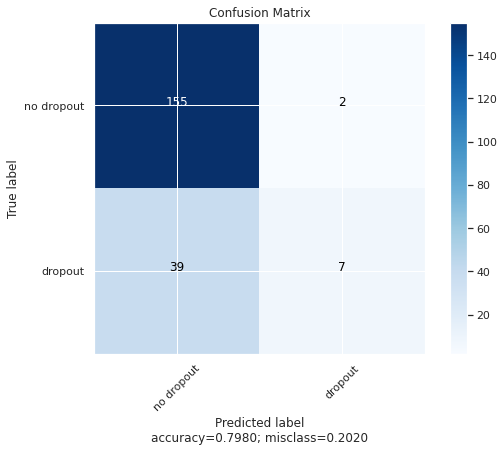

In [ ]:
print(rf_gscv.best_params_)
best_estimator = rf_gscv.best_estimator_
preds = best_estimator.predict(unscaled_X_test)
scores_and_metrics(best_estimator, preds, unscaled_X_train, unscaled_y_train, cv, unscaled_y_test)
show_confusion_matrix(unscaled_y_test, preds, ['no dropout', 'dropout'])

#### Q: I don't totally understand what's causing the 25% drop in recall here.


## FPR, TPR, and ROC curve for Random Forest

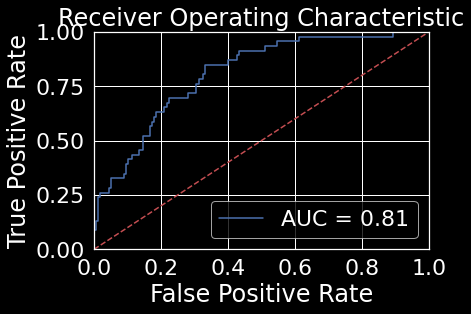

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
best_estimator = rf_gscv.best_estimator_
probs = best_estimator.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## First Iteration Gradient Boosting Grid Search

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter. Had to
# comment out some parameters because of too many combinations leading
# to excessive run time even on small dataset
params= {'loss': ('deviance', 'exponential'),
         'learning_rate': [0.05, 0.1, 0.15],
        #  'n_estimators': [100, 200, 300],
        #  'subsample': [0.8, 1.0],
         'criterion': ('friedman_mse', 'mse', 'mae'),
        #  'min_samples_split': [2, 4, 8],
        #  'min_samples_leaf': [1, 2, 3],
        #  'max_depth': [3, 5],
        #  'min_impurity_decrease': [0.0, 0.1],
         }


gb_gscv = GridSearchCV(estimator=GradientBoostingClassifier(
                                    random_state=42),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
gb_gscv.fit(X_train, y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 81.666 seconds ---


{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance'}
Cross validation scores: 80.18% [0.75460123 0.82208589 0.80246914 0.82098765 0.80864198] 

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       157
           1       0.78      0.30      0.44        46

    accuracy                           0.82       203
   macro avg       0.80      0.64      0.67       203
weighted avg       0.82      0.82      0.79       203

Cross-validation in 0.786 seconds.


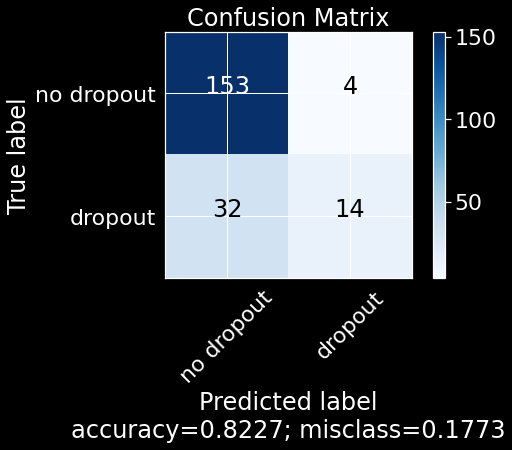

In [ ]:
print(gb_gscv.best_params_)
best_estimator = gb_gscv.best_estimator_
preds = best_estimator.predict(X_test)
scores_and_metrics(best_estimator, preds, X_train, y_train, cv, y_test)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])

So far precision and recall are slightly worse than both linear regression and random forest. Let's see if it's possible to improve. Gradient boosting is robust to overfitting, so maybe increasing the number of estimators will improve the model.

## Second Iteration Gradient Boosting Grid Search

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter. Had to
# comment out some parameters because of too many combinations leading
# to excessive run time even on small dataset
params= {#'loss': ('deviance', 'exponential'),
        #  'learning_rate': [0.05, 0.1, 0.15],
         'n_estimators': [1, 2, 3, 4, 5, 6]
        #  'subsample': [0.8, 1.0],
        #  'criterion': ('friedman_mse', 'mse', 'mae'),
        #  'min_samples_split': [2, 4, 8],
        #  'min_samples_leaf': [1, 2, 3],
        #  'max_depth': [3, 5, 7],
        #  'min_impurity_decrease': [0.0, 0.1],
         }


gb_gscv_2 = GridSearchCV(estimator=GradientBoostingClassifier(
                                    random_state=42,
                                    criterion='mae',
                                    learning_rate=0.5,
                                    loss='exponential',
                                    max_depth=3,
                                    ),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
gb_gscv_2.fit(X_train, y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 2.678 seconds ---


{'n_estimators': 2}
Cross validation scores: 78.69% [0.7791411  0.79754601 0.80864198 0.78395062 0.7654321 ] 

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       157
           1       0.67      0.09      0.15        46

    accuracy                           0.78       203
   macro avg       0.73      0.54      0.51       203
weighted avg       0.76      0.78      0.71       203

Cross-validation in 0.249 seconds.


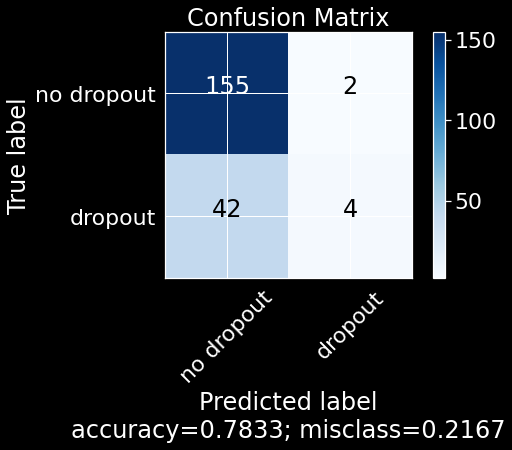

In [ ]:
print(gb_gscv_2.best_params_)
best_estimator = gb_gscv_2.best_estimator_
preds = best_estimator.predict(X_test)
scores_and_metrics(best_estimator, preds, X_train, y_train, cv, y_test)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])

**Iteration One Decision Tree Grid Search**

In [ ]:
start_time = time.time()

# Setting parameters for 'params' GridSearchCV parameter. Had to
# comment out some parameters because of too many combinations leading
# to excessive run time even on small dataset
params= {'criterion': ('gini', 'entropy'),
         'splitter': ('best', 'random'),
         'max_depth': [3, 5, 7],
         'min_samples_split': [2, 4],
         'min_samples_leaf': [1,3],
         }


dt_gscv = GridSearchCV(estimator=DecisionTreeClassifier(
                                    random_state=42),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
dt_gscv.fit(X_train, y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 1.59 seconds ---


{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'random'}
Cross validation scores: 78.69% [0.80981595 0.78527607 0.7962963  0.75925926 0.78395062] 

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       157
           1       0.62      0.22      0.32        46

    accuracy                           0.79       203
   macro avg       0.72      0.59      0.60       203
weighted avg       0.77      0.79      0.75       203

Cross-validation in 0.038 seconds.


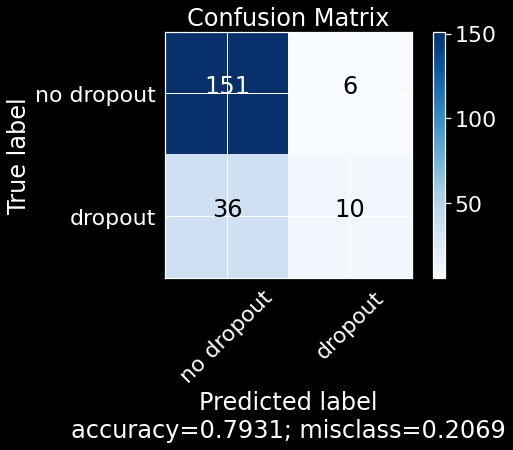

In [ ]:
print(dt_gscv.best_params_)
best_estimator = dt_gscv.best_estimator_
preds = best_estimator.predict(X_test)
scores_and_metrics(best_estimator, preds, X_train, y_train, cv, y_test)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])

Decision Tree has lowest recall of any model so far. Let's see if it's possible to tune.

**Iteration Two Decision Tree Grid Search**

In [ ]:
start_time = time.time()
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
# Setting parameters for 'params' GridSearchCV parameter. Had to
# comment out some parameters because of too many combinations leading
# to excessive run time even on small dataset
params= {'max_depth': [1, 2, 3, 4],
         'min_samples_split': [2, 3],
         'min_samples_leaf': [1,2],
         }


dt_gscv = GridSearchCV(estimator=DecisionTreeClassifier(
                                    random_state=42,
                                    criterion='entropy',
                                    splitter='random',
                                    ),
                        param_grid=params,
                        n_jobs=None,
                        cv=5,
                        return_train_score=True)
dt_gscv.fit(X_train, y_train)
print("--- %s seconds ---" % (round(time.time() - start_time, 3)))

--- 0.486 seconds ---


{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Cross validation scores: 80.05% [0.79754601 0.79141104 0.80246914 0.80864198 0.80246914] 

              precision    recall  f1-score   support

           0       0.79      0.98      0.87       157
           1       0.62      0.11      0.19        46

    accuracy                           0.78       203
   macro avg       0.71      0.54      0.53       203
weighted avg       0.75      0.78      0.72       203

Cross-validation in 0.033 seconds.


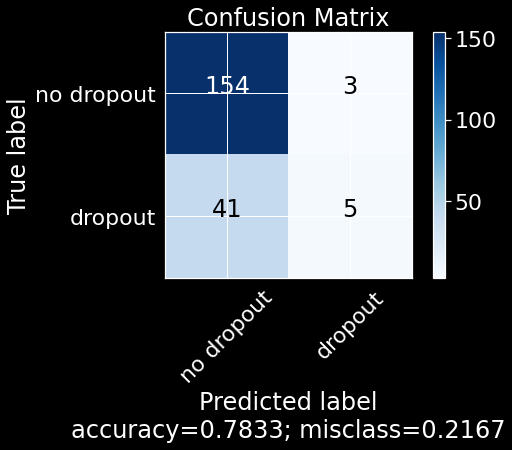

In [ ]:
print(dt_gscv.best_params_)
best_estimator = dt_gscv.best_estimator_
preds = best_estimator.predict(X_test)
scores_and_metrics(best_estimator, preds, X_train, y_train, cv, y_test)
show_confusion_matrix(y_test, preds, ['no dropout', 'dropout'])

Adding hyperparameter options to Grid Search does not produce a more accurate model.

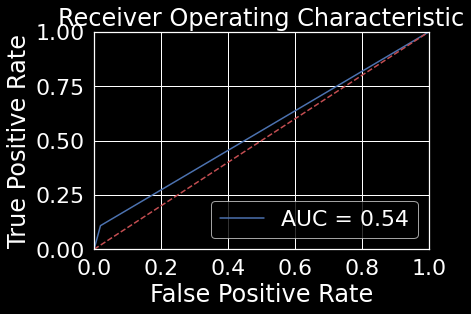

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
best_estimator = dt_gscv.best_estimator_
probs = best_estimator.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()